In [ ]:
library(ggplot2)
library(gplots)
library(ggthemes)
library(Bolstad2)
options(repr.plot.width=8, repr.plot.height=9.33)
library(mvtnorm) 
library(rjags)
require(rjags)
#library("GGally")
library("PerformanceAnalytics")

## Exercise 1
 
 Students from the Bachelor degree in Physics performed an experiment to study the Zeeman effect.
The apparatus contains a Ne source lamp whose position can be changed. During the setting up of the apparatus, the source position has to be adjusted in order to maximize the intensity of the detected light signal.

The following table gives the position of the source (in mm) and the corresponding height of the peak (arbitrary units) for the wavelength under study:


| xi | 2.44 | 3.49 |3.78 |3.31| 3.18| 3.15| 3.1 |3.0 |3.6| 3.4  |
|------|------|------|------|------|------|------|------|------|------|------|
|  yi  |  129| 464| 189| 562| 589| 598| 606| 562| 360 |494|


Assume a quadratic dependence of the peak height, yi as a function of the source position xi,

$f(x) = c_0 + c_1x + c_2x^2$


All the measured values are affected by a Gaussian noise with zero mean, such that

$yi = f(x_i) + \epsilon$

where $\epsilon$ follows a normal distribution with mean $\mu = 0$ and unknown standard deviation, $\sigma$

A) Build a Markov Chain Monte Carlo to estimate the best parameters of the quadratic dependence
of the data and the noise that affects the measured data. 

As can be seen from our data, the students forgot to take measurements in the region $x \in (2.44; 3.0)$



In [2]:
#metropolis algorithm

metrop <- function(func, thetaInit, Nburnin, Nsamp, sampleCov, verbose, 
                   demo=FALSE, ...) {

    Ntheta   <- length(thetaInit)
    thetaCur <- thetaInit
    funcCur  <- func(thetaInit, ...) # log10
    funcSamp <- matrix(data=NA, nrow=Nsamp, ncol=2+Ntheta) 

    # funcSamp will be filled and returned
    nAccept  <- 0
    acceptRate <- 0
    if(demo) {
        thetaPropAll <- matrix(data=NA, nrow=Nsamp, ncol=Ntheta)
    }
  
    for(n in 1:(Nburnin+Nsamp)) {

        # Metropolis algorithm. No Hastings factor for symmetric proposal
        if(is.null(dim(sampleCov))) { # theta and sampleCov are scalars
            thetaProp <- rnorm(n=1, mean=thetaCur, sd=sqrt(sampleCov))

        }else {

        thetaProp <- rmvnorm(n=1, mean=thetaCur, sigma=sampleCov, 
                            method="eigen")
        }

        funcProp  <- func(thetaProp, ...) 
        logMR <- sum(funcProp) - sum(funcCur) # log10 of the Metropolis ratio
        #cat(n, thetaCur, funcCur, ":", thetaProp, funcProp, "\n")

        if(logMR>=0 || logMR>log10(runif(1, min=0, max=1))) {
            thetaCur   <- thetaProp
            funcCur    <- funcProp
            nAccept    <- nAccept + 1
            acceptRate <- nAccept/n
            }
        if(n>Nburnin) {
            funcSamp[n-Nburnin,1:2] <- funcCur
            funcSamp[n-Nburnin,3:(2+Ntheta)] <- thetaCur

        if(demo) {
            thetaPropAll[n-Nburnin,1:Ntheta] <- thetaProp
                }
        }

        # Diagnostics
        if( is.finite(verbose) && (n%%verbose==0 || n==Nburnin+Nsamp) ) {
            s1 <- noquote(formatC(n,          format="d", digits=5, flag=""))
            s2 <- noquote(formatC(Nburnin,    format="g", digits=5, flag=""))
            s3 <- noquote(formatC(Nsamp,      format="g", digits=5, flag=""))
            s4 <- noquote(formatC(acceptRate, format="f", digits=4, width=7, flag=""))
            cat(s1, "of", s2, "+", s3, s4, "\n")
        }

    }

    if(demo) {
        return(list(funcSamp=funcSamp, thetaPropAll=thetaPropAll))
        } 
    else {
        return(funcSamp)
    }

}

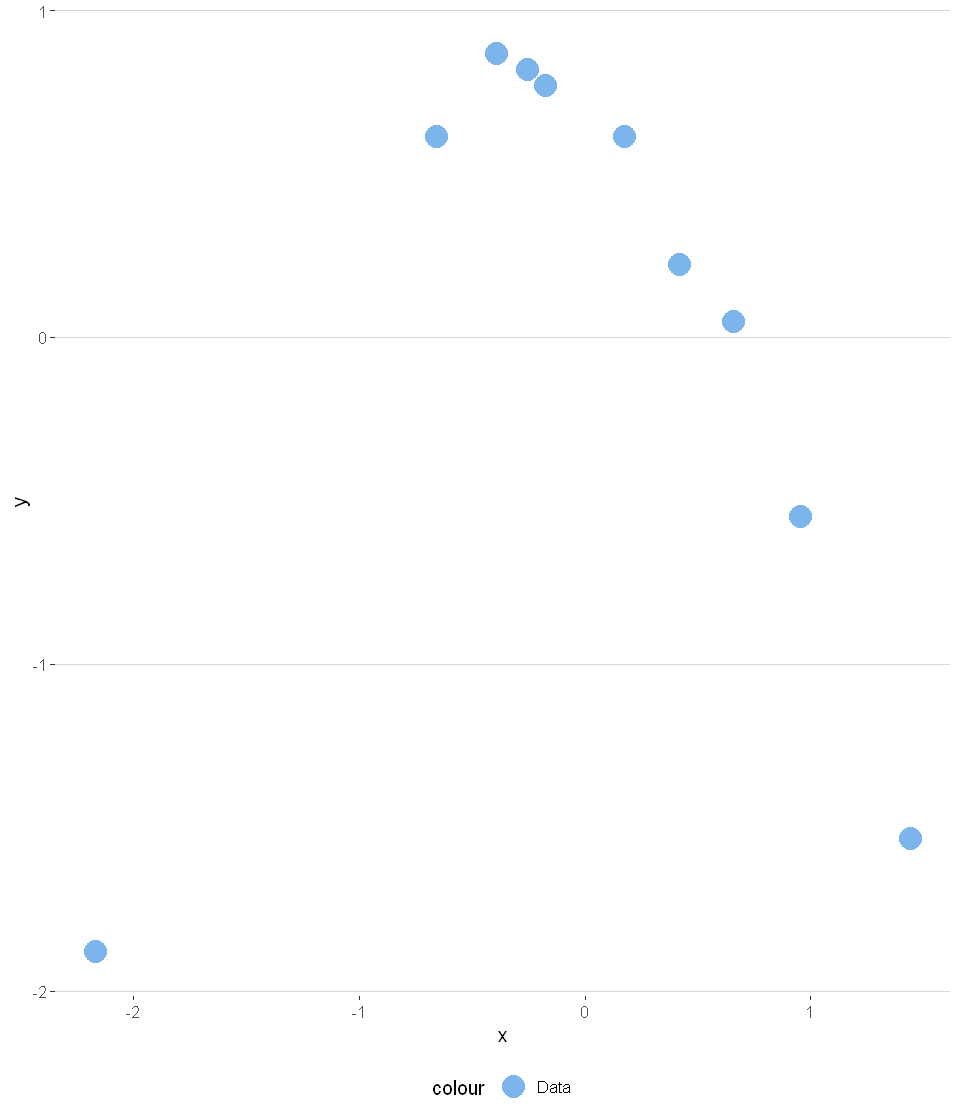

In [3]:
#data with noise
xi <- c( 2.44, 3.49, 3.78, 3.31, 3.18, 3.15, 3.1, 3.0, 3.6, 3.4)
yi <- c(129, 464, 189, 562, 589, 598, 606, 562, 360, 494)

#we rescale the data to fit the model
x <- (xi - mean(xi))/sd(xi)
y <- (yi - mean(yi))/sd(yi)

obsdata <- data.frame(cbind(x,y))
#order data
obsdata <- obsdata[order(obsdata$x), ] 

#plot data
ggplot(data.frame(x, y), aes(x, y , col = "Data"))  + theme_hc()+ scale_colour_hc()+ geom_point(size = 6)

In [4]:
#now we have 4 paramenter
#prior of the model gaussian on bo
#b1 is the slope thansform in alpha = arctan(b1) and is uniform between 0 and 2pi
#gaussian prior for b2 
#noise transform to log(sigma) we used an improper uniform prior

# Return c(log10(prior), log10(likelihood)) (each generally unnormalized) of the quadratic model
logpost.quadraticmodel <- function(theta, obsdata) {

    logprior <- logprior.quadraticmodel(theta)
    
    if(is.finite(logprior)) { # only evaluate model if parameters are sensible
        return( c(logprior, loglike.quadraticmodel(theta, obsdata)) )
    } else {
        return( c(-Inf, -Inf) )
    }
}

# Return log10(likelihood) for parameters theta and obsdata
loglike.quadraticmodel <- function(theta, obsdata) {
    # convert alpha to b_1 and log10(ysig) to ysig
    theta[2] <- tan(theta[2])
    theta[4] <- 10^theta[4]
    modPred <- drop( theta[1:3] %*% t(cbind(1,obsdata$x,obsdata$x^2)) )
    # Dimensions in above mixed vector/matrix multiplication: [Ndat] = [P] %*% [P x Ndat] 
    # dnorm(..., log=TRUE) returns log base e, so multiply by 1/ln(10) = 0.4342945
    logLike <- (1/log(10))*sum( dnorm(modPred - obsdata$y, mean=0, sd=theta[4], log=TRUE) )
    return(logLike)
}

# Return log10(unnormalized prior)
logprior.quadraticmodel <- function(theta) {
    
    b0Prior      <- dnorm(theta[1], mean=0, sd=10)
    alphaPrior   <- 1
    b2Prior      <- dnorm(theta[3], mean=0, sd=5)
    logysigPrior <- 1 
    logPrior <- sum( log10(b0Prior), log10(alphaPrior), log10(b2Prior), log10(logysigPrior) )
    return(logPrior)
}

In [5]:
#in order to initialize it, we use lm() to have good initial param
lsfit <- lm(y ~ x + I(x^2), data = obsdata)
lsfit

# initial log(sigma)
sqrt(mean(lsfit$residuals^2))


Call:
lm(formula = y ~ x + I(x^2), data = obsdata)

Coefficients:
(Intercept)            x       I(x^2)  
     0.6929      -0.4864      -0.7699  


[1] 0.06868222

In [6]:
#parameters step size
sampleCov <- diag(c(0.1, 0.01, 0.01, 0.01)^2)

#initial value
thetaInit <- c(lsfit$coefficients, sqrt(mean(lsfit$residuals^2)))


# Run the MCMC to find postSamp, samples of the posterior PDF
set.seed(250)
allSamp <-metrop(func=logpost.quadraticmodel, thetaInit=thetaInit, Nburnin=5e4, Nsamp=3e5,
                   sampleCov=sampleCov, verbose=2e3, obsdata=obsdata)


  2000 of  50000 +  3e+05  0.6345 
  4000 of  50000 +  3e+05  0.4407 
  6000 of  50000 +  3e+05  0.3721 
  8000 of  50000 +  3e+05  0.3395 
 10000 of  50000 +  3e+05  0.3119 
 12000 of  50000 +  3e+05  0.3103 
 14000 of  50000 +  3e+05  0.3189 
 16000 of  50000 +  3e+05  0.3141 
 18000 of  50000 +  3e+05  0.3044 
 20000 of  50000 +  3e+05  0.3095 
 22000 of  50000 +  3e+05  0.3174 
 24000 of  50000 +  3e+05  0.3125 
 26000 of  50000 +  3e+05  0.3105 
 28000 of  50000 +  3e+05  0.3116 
 30000 of  50000 +  3e+05  0.3079 
 32000 of  50000 +  3e+05  0.3033 
 34000 of  50000 +  3e+05  0.3130 
 36000 of  50000 +  3e+05  0.3154 
 38000 of  50000 +  3e+05  0.3129 
 40000 of  50000 +  3e+05  0.3159 
 42000 of  50000 +  3e+05  0.3206 
 44000 of  50000 +  3e+05  0.3189 
 46000 of  50000 +  3e+05  0.3125 
 48000 of  50000 +  3e+05  0.3064 
 50000 of  50000 +  3e+05  0.3036 
 52000 of  50000 +  3e+05  0.3003 
 54000 of  50000 +  3e+05  0.3047 
 56000 of  50000 +  3e+05  0.3048 
 58000 of  50000 +  

In [7]:
# 10^(allSamp[,1]+allSamp[,2]) is the unnormalized posterior at each sample
#thinning
thinSel  <- seq(from=1, to=nrow(allSamp), by=200) # thin by factor 100
postSamp <- allSamp[thinSel,]

null device 
          1

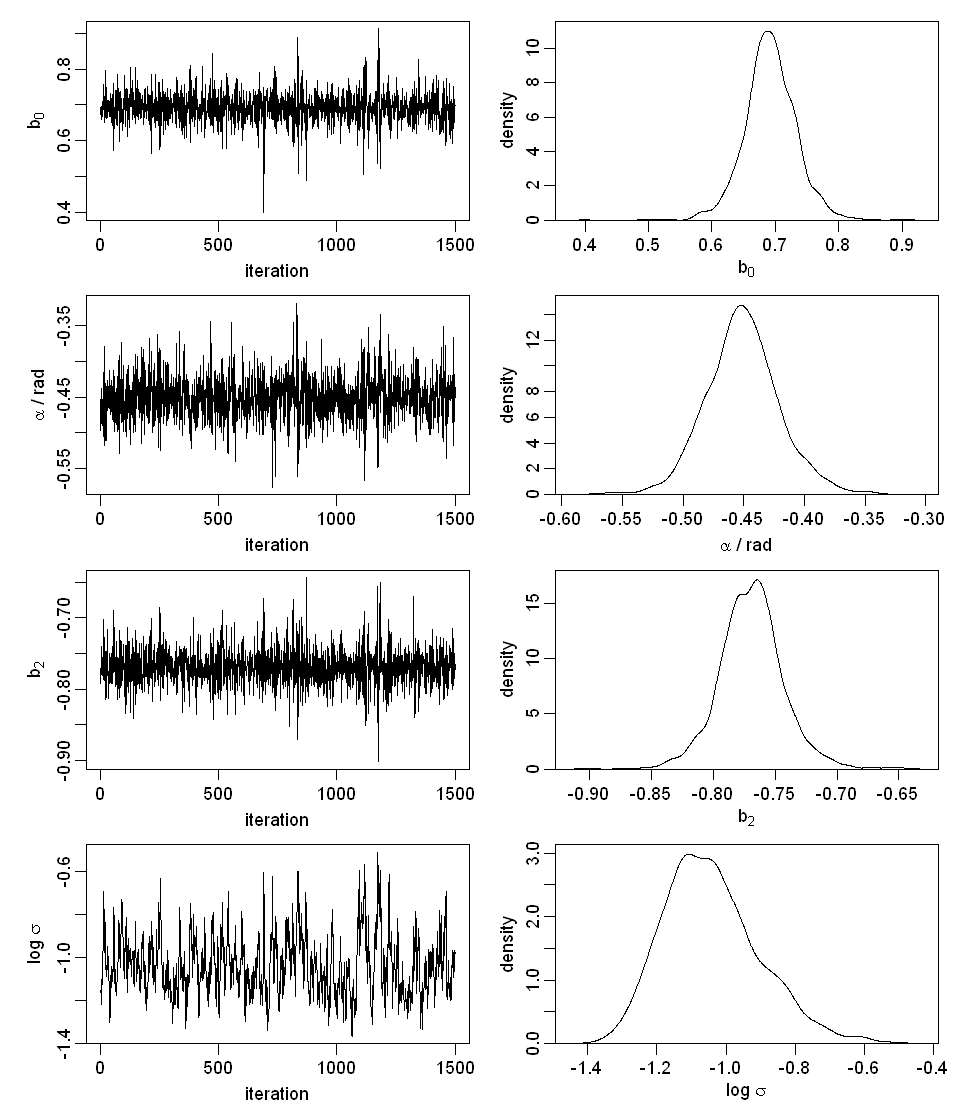

In [8]:
# Plot MCMC chains 

par(mfrow=c(4,2), mar=c(3.0,3.5,0.5,0.5), oma=0.5*c(1,1,1,1), mgp=c(1.8,0.6,0), cex=0.9)

parnames <- c(expression(b[0]), expression(paste(alpha, " / rad")), expression(b[2]), 
              expression(paste(log, " ", sigma)))

for(j in 3:6) { # columns of postSamp
    plot(1:nrow(postSamp), postSamp[,j], type="l", xlab="iteration", ylab=parnames[j-2])
    postDen <- density(postSamp[,j], n=2^10)
    plot(postDen$x, postDen$y, type="l", lwd=1.5, yaxs="i", ylim=1.05*c(0,max(postDen$y)),
         xlab=parnames[j-2], ylab="density")
  
}

dev.off()

In [37]:
colnames(postSamp) <- c("", ""," b0"," alpha", "b2", "log.sigma")

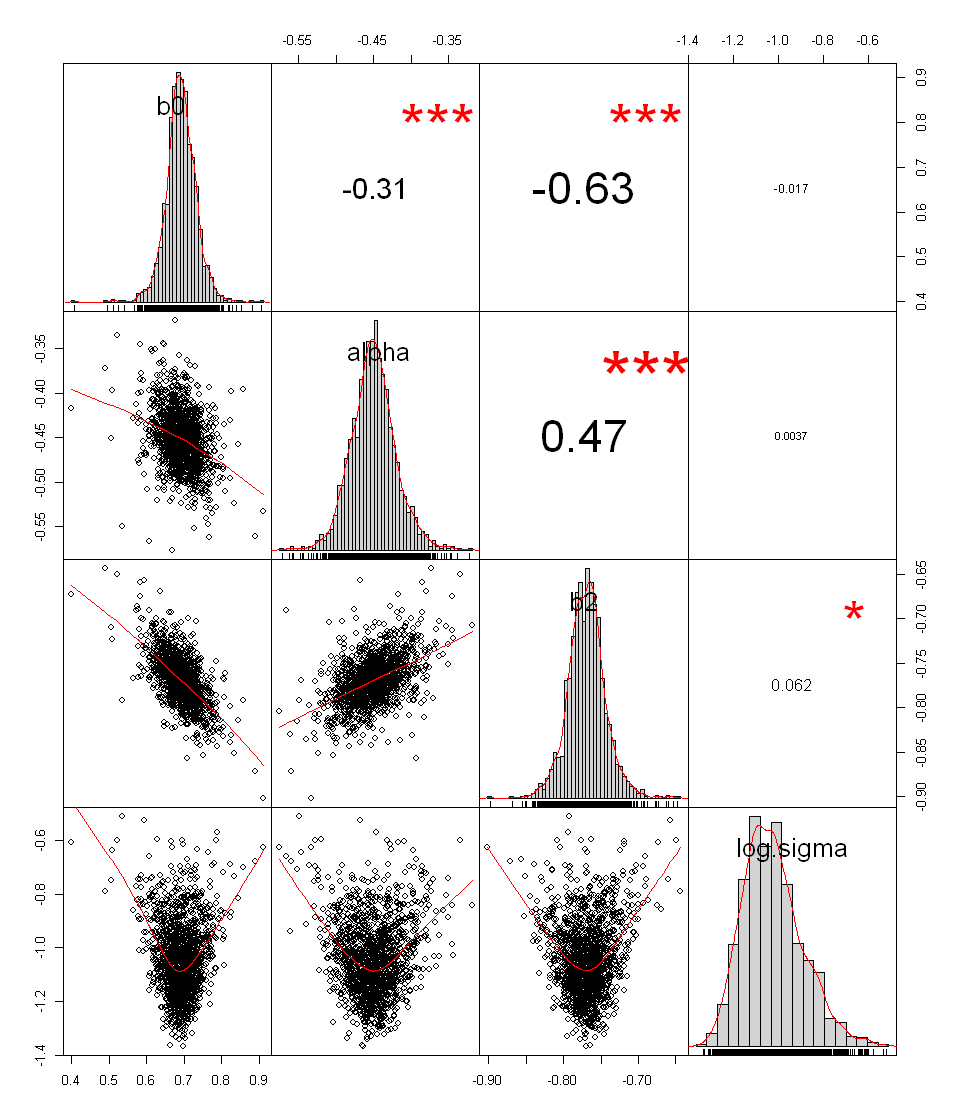

In [38]:
options(repr.plot.width=8, repr.plot.height=9.33)
chart.Correlation(postSamp[,3:6], histogram = T, pch= 19)

In [10]:
# Find MAP and mean solutions.
# MAP = Maximum A Posteriori, i.e. peak of posterior.
# MAP is not the peak in each 1D PDF, but the peak of the 4D PDF.
# mean is easy, because samples have been drawn from the (unnormalized) posterior.
posMAP    <- which.max(postSamp[,1]+postSamp[,2]) 
thetaMAP  <- postSamp[posMAP, 3:6]
thetaMean <- apply(postSamp[,3:6], 2, mean)
covar <- cov(postSamp[, 3:6])
corr <- cor(postSamp[, 3:6])

In [11]:
# Best estimates:
b0.maxpost <- thetaMAP[1]
b1.maxpost <- tan(thetaMAP[2])
b2.maxpost <- thetaMAP[3]
sigma.maxpost <- 10^thetaMAP[4]

cat("Maximum posteriori:")
cat("b0:",b0.maxpost,'\n')
cat("b1:",b1.maxpost,'\n')
cat("b2:",b2.maxpost,'\n')
cat("Sigma:",sigma.maxpost,'\n')


Maximum posteriori:b0: 0.6907129 
b1: -0.4815103 
b2: -0.7684691 
Sigma: 0.07445502 


In [12]:
# Mean solutions
b0.mean <- thetaMean[1]
b1.mean <- tan(thetaMean[2])
b2.mean <- thetaMean[3]
sigma.mean <- 10^thetaMean[4]
cat("\nMean:")
cat("\nb0:",b0.mean)
cat("\nb1:",b1.mean)
cat("\nb2:",b2.mean)
cat("\nsigma:",sigma.mean,'\n')


Mean:
b0: 0.6919934
b1: -0.4840069
b2: -0.7690336
sigma: 0.09086144 


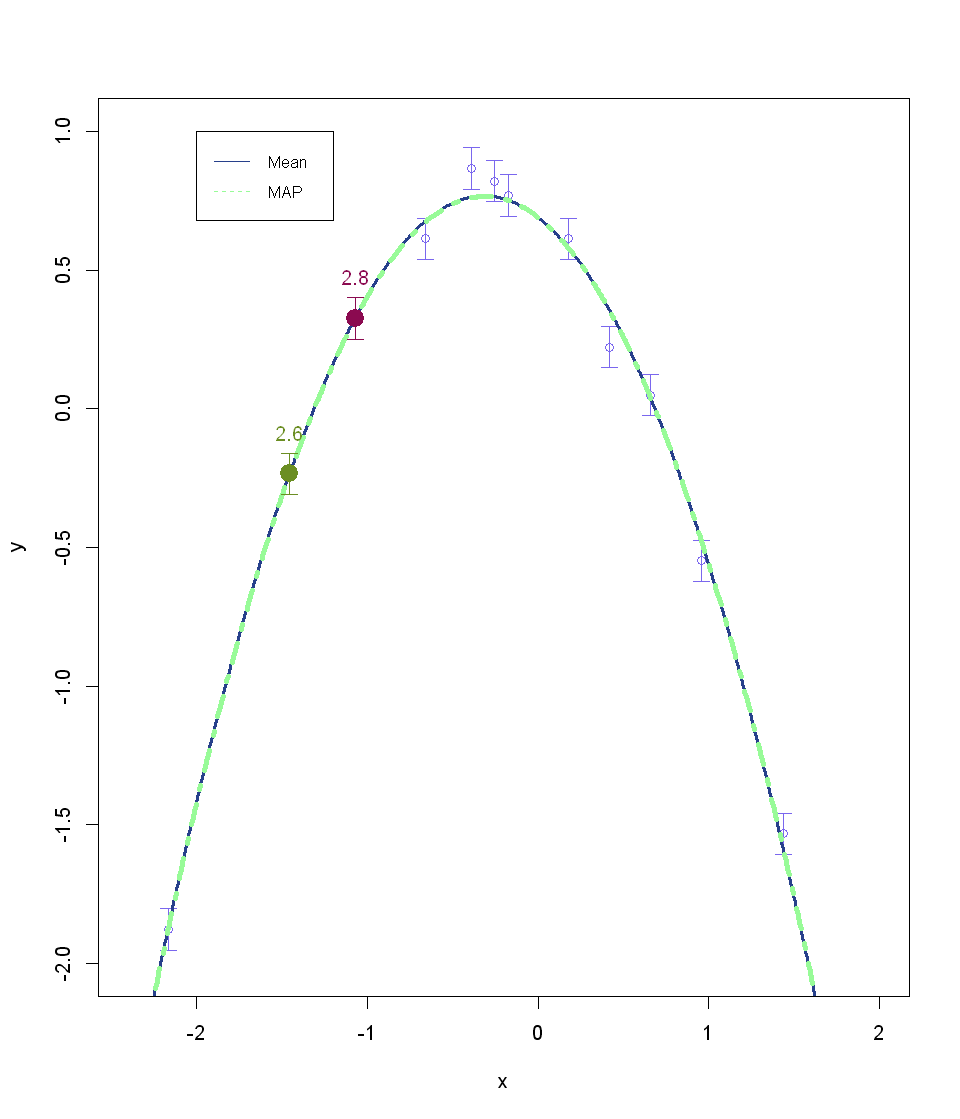

In [13]:
# Overplot MAP solution with original data
xrange <- c(-2.4,2)
ylim<-c(-2,1)

plotCI(obsdata$x, obsdata$y,  xlab="x", ylab="y", uiw=10^thetaMAP[4], gap=0, col='slateblue2',
       xlim=xrange, ylim=ylim) 

# Mean model
xsamp <- seq(from=xrange[1], to=xrange[2], length.out=500)
# %*% means an inner product
ysamp <- cbind(1,xsamp,xsamp^2) %*% as.matrix(c(b0.mean, b1.mean, b2.mean)) 
lines(xsamp, (ysamp), lwd=3, col = "royalblue4") 


# MAP model
ysamp <- cbind(1,xsamp,xsamp^2) %*% as.matrix(c(b0.maxpost, b1.maxpost, b2.maxpost))
lines(xsamp, drop(ysamp), lwd=4,lty=4,col='palegreen') 




#B) run a Markov Chain Monte Carlo to predict peak height measurements at $x_1 = 2.8 mm$ and $x_2 = 2.6 mm$


x1_new<-2.8
x_dat <- append(xi,x1_new)

#rescale the data in order to map with the other data
x1 <- (x1_new-mean(x_dat))/sd(x_dat)  
y1 <- cbind(1,x1,x1^2) %*% as.matrix(c(b0.mean, b1.mean, b2.mean)) 

x2_new <- 2.6
x_dat <- append(xi,x2_new)
#rescale the data 
x2 <- (x2_new-mean(x_dat))/sd(x_dat)  
y2 <- cbind(1,x2,x2^2) %*% as.matrix(c(b0.mean, b1.mean, b2.mean)) 

par(new=TRUE)    
plotCI(c(x1,x2), c(y1,y2),  xlab="x", ylab="y", uiw=10^thetaMAP[4], gap=0,
       col=c('deeppink4','olivedrab'), pch = 21, pt.bg=c("deeppink4"," olivedrab"), xlim=xrange, ylim=ylim, cex = 2)

text(x1, y1+0.15, "2.8", col = "deeppink4")

text(x2, y2+0.15, "2.6", col = "olivedrab")

legend(-2, 1, legend=c("Mean", "MAP"),
       col=c("royalblue4", "palegreen"), lty=1:4, cex=0.8)


# Exercise 2

The number of British coal mine disasters has been recorded from 1851 to 1962. By looking at the
data it seems that the number of incidents decreased towards the end of the sampling period. We
model the data as follows:

- before some year, we call $\tau$ , the data follow a Poisson distribution, where the logarithm of the mean value, $log \mu t = b_0$, while for later years, we can model it as $log \mu_t = b_0 + b_1$

the dependence can be modeled as follows $y_t \sim Pois(\mu_t)$, where $log \mu_t = b_0 + b_1Step(t - \tau )$

 implement the model in $\textit{jags}$, trying to infer the parameters $b_0$, $b_1$ and $\tau$.
 
 the step function is implemented, in BUGS, as step(x) and return 1 if $x\geq 0$ and 0 otherwise
 
Assign a uniform prior to $b_0$, $b_1$ and a uniform prior in the interval $(1;N)$, where $N = 112$ is the number of years our data span on 


Finally, here is our data:

    data <- NULL
    
    data$D <- c ( 4 , 5 , 4 , 1 , 0 , 4 , 3 , 4 , 0 , 6 ,
    3 , 3 , 4 , 0 , 2 , 6 , 3 , 3 , 5 , 4 , 5 , 3 , 1 , 4 , 4 , 1 , 5 , 5 , 3 , 4 , 2 , 5 , 2 , 2 , 3 , 4 , 2 , 1 , 3 , 2 ,
    1 , 1 , 1 , 1 , 1 , 3 , 0 , 0 , 1 , 0 , 1 , 1 , 0 , 0 , 3 , 1 , 0 , 3 , 2 , 2 ,
    0 , 1 , 1 , 1 , 0 , 1 , 0 , 1 , 0 , 0 , 0 , 2 , 1 , 0 , 0 , 0 , 1 , 1 , 0 , 2 ,
    2 , 3 , 1 , 1 , 2 , 1 , 1 , 1 , 1 , 2 , 4 , 2 , 0 , 0 , 0 , 1 , 4 , 0 , 0 , 0 ,
    1 , 0 , 0 , 0 , 0 , 0 , 1 , 0 , 0 , 1 , 0 , 0 )
    
    data$N <- 112


before running jags, assign an initial value to the parameters as follows: $b_0 = 0$, $b_1 = 0 $and $\tau = 50$

explore the features of the chains and try to understand the effects of the burn-in, and thinning

plot the posterior distributions of the parameters and extract their mean values, and 95

In [2]:
#N=112
D=c(4,5,4,1,0,4,3,4,0,6,
 3,3,4,0,2,6,3,3,5,4,5,3,1,4,4,1,5,5,3,4,2,5,2,2,3,4,2,1,3,2,
 1,1,1,1,1,3,0,0,1,0,1,1,0,0,3,1,0,3,2,2,
 0,1,1,1,0,1,0,1,0,0,0,2,1,0,0,0,1,1,0,2,
 2,3,1,1,2,1,1,1,1,2,4,2,0,0,0,1,4,0,0,0,
 1,0,0,0,0,0,1,0,0,1,0,0)

#data=list("N","D")
data <- NULL
data$D <- D    # Set of observations
data$N <- length(D)
#data$n_next <- 112
data

$D
  [1] 4 5 4 1 0 4 3 4 0 6 3 3 4 0 2 6 3 3 5 4 5 3 1 4 4 1 5 5 3 4 2 5 2 2 3 4 2
 [38] 1 3 2 1 1 1 1 1 3 0 0 1 0 1 1 0 0 3 1 0 3 2 2 0 1 1 1 0 1 0 1 0 0 0 2 1 0
 [75] 0 0 1 1 0 2 2 3 1 1 2 1 1 1 1 2 4 2 0 0 0 1 4 0 0 0 1 0 0 0 0 0 1 0 0 1 0
[112] 0

$N
[1] 112

In [3]:
inits <- list(b0 =0, b1= 0 , tau = 50)
str(inits)
jm <- jags.model("coil.bug" , data, inits = inits)

List of 3
 $ b0 : num 0
 $ b1 : num 0
 $ tau: num 50
Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 112
   Unobserved stochastic nodes: 3
   Total graph size: 789

Initializing model



In [4]:
# Update the Markov chain (Burn-in)
update(jm, 1000)
chain <- coda.samples(jm,  variable.names=c("b0","b1","tau"),
                      n.iter=1e5, thin = 100)

In [5]:
print(summary(chain))


Iterations = 2100:102000
Thinning interval = 100 
Number of chains = 1 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

      Mean      SD Naive SE Time-series SE
b0   1.137 0.09565 0.003025       0.003025
b1  -1.260 0.15799 0.004996       0.004996
tau 39.618 2.07778 0.065705       0.061744

2. Quantiles for each variable:

       2.5%    25%    50%    75%   97.5%
b0   0.9537  1.069  1.141  1.202  1.3205
b1  -1.5880 -1.365 -1.262 -1.153 -0.9748
tau 36.1368 37.851 39.875 40.834 43.8807



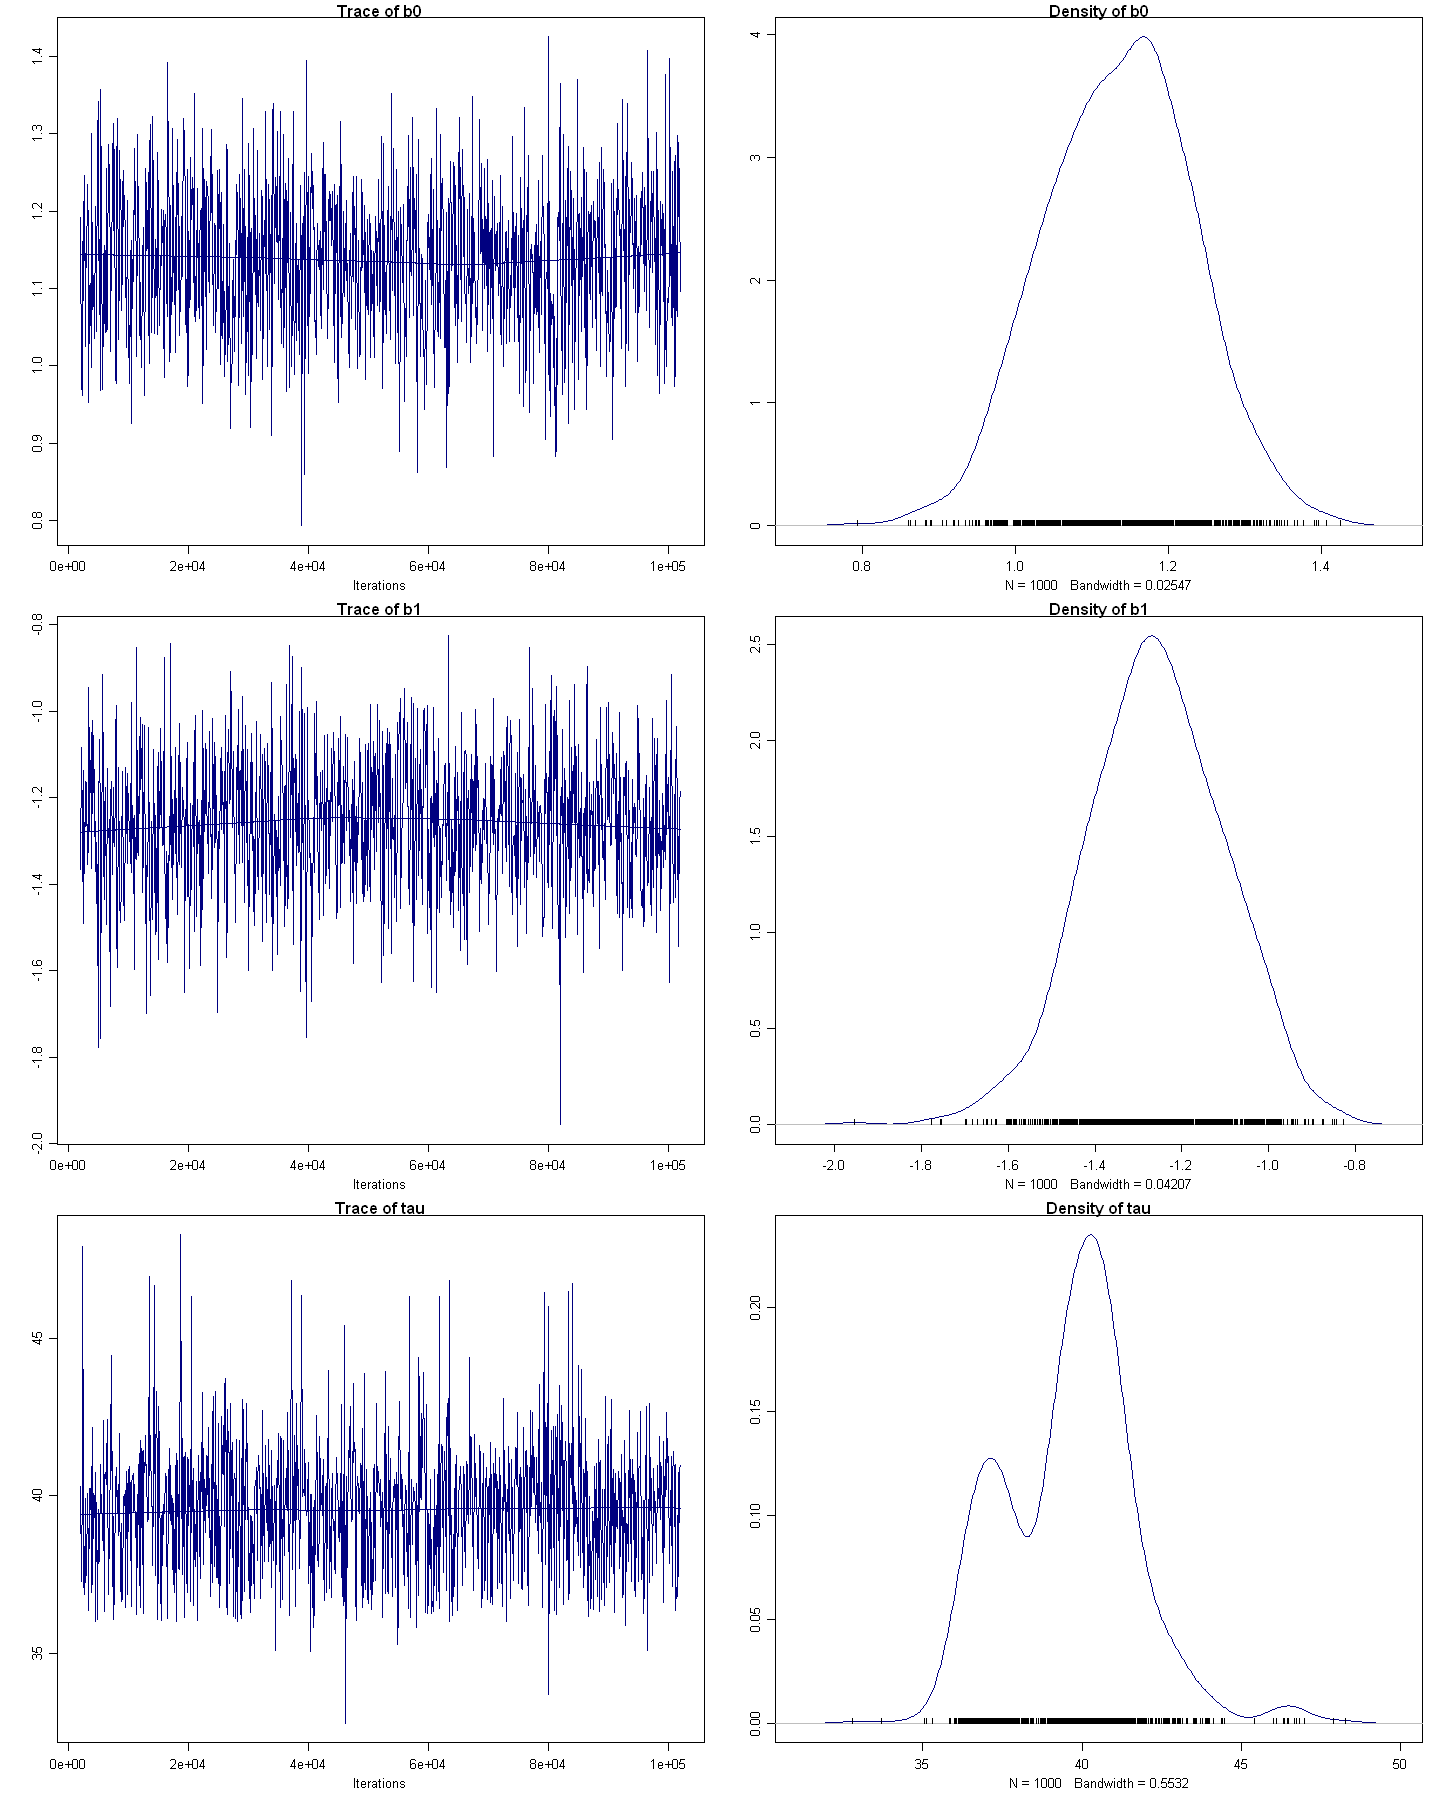

In [6]:
options(repr.plot.width=12, repr.plot.height=15)
chain_plot <- TRUE
if (chain_plot) {
  par(mfrow=c(2,3), mgp=c(2.0,0.8,0), mar=c(3.5,3.5,1,1), oma=0.1*c(1,1,1,1))
  plot(chain, col="navy")
}

In [7]:
str(chain)
summary(chain)

List of 1
 $ : 'mcmc' num [1:1000, 1:3] 1.192 0.969 1.16 0.962 1.204 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:3] "b0" "b1" "tau"
  ..- attr(*, "mcpar")= num [1:3] 2100 102000 100
 - attr(*, "class")= chr "mcmc.list"



Iterations = 2100:102000
Thinning interval = 100 
Number of chains = 1 
Sample size per chain = 1000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

      Mean      SD Naive SE Time-series SE
b0   1.137 0.09565 0.003025       0.003025
b1  -1.260 0.15799 0.004996       0.004996
tau 39.618 2.07778 0.065705       0.061744

2. Quantiles for each variable:

       2.5%    25%    50%    75%   97.5%
b0   0.9537  1.069  1.141  1.202  1.3205
b1  -1.5880 -1.365 -1.262 -1.153 -0.9748
tau 36.1368 37.851 39.875 40.834 43.8807


In [8]:
summ <- summary(chain)
summ$statistics[,1:2]


,Mean,SD
b0,1.136618,0.09565106
b1,-1.259968,0.15798762
tau,39.617541,2.07778240


In [9]:
summ$quantiles
cat("\n95% credibility interval are:")
cat("\nb0 :",summ$quantiles[1,1],'-',summ$quantiles[1,5])
cat("\nb1 :",summ$quantiles[2,1],'-',summ$quantiles[2,5])
cat("\ntau :",summ$quantiles[3,1],'-',summ$quantiles[3,5])


,2.5%,25%,50%,75%,97.5%
b0,0.953667,1.069212,1.140535,1.201545,1.3204658
b1,-1.588030,-1.365374,-1.262043,-1.152865,-0.9748309
tau,36.136839,37.850786,39.875232,40.834206,43.8807500



95% credibility interval are:
b0 : 0.953667 - 1.320466
b1 : -1.58803 - -0.9748309
tau : 36.13684 - 43.88075

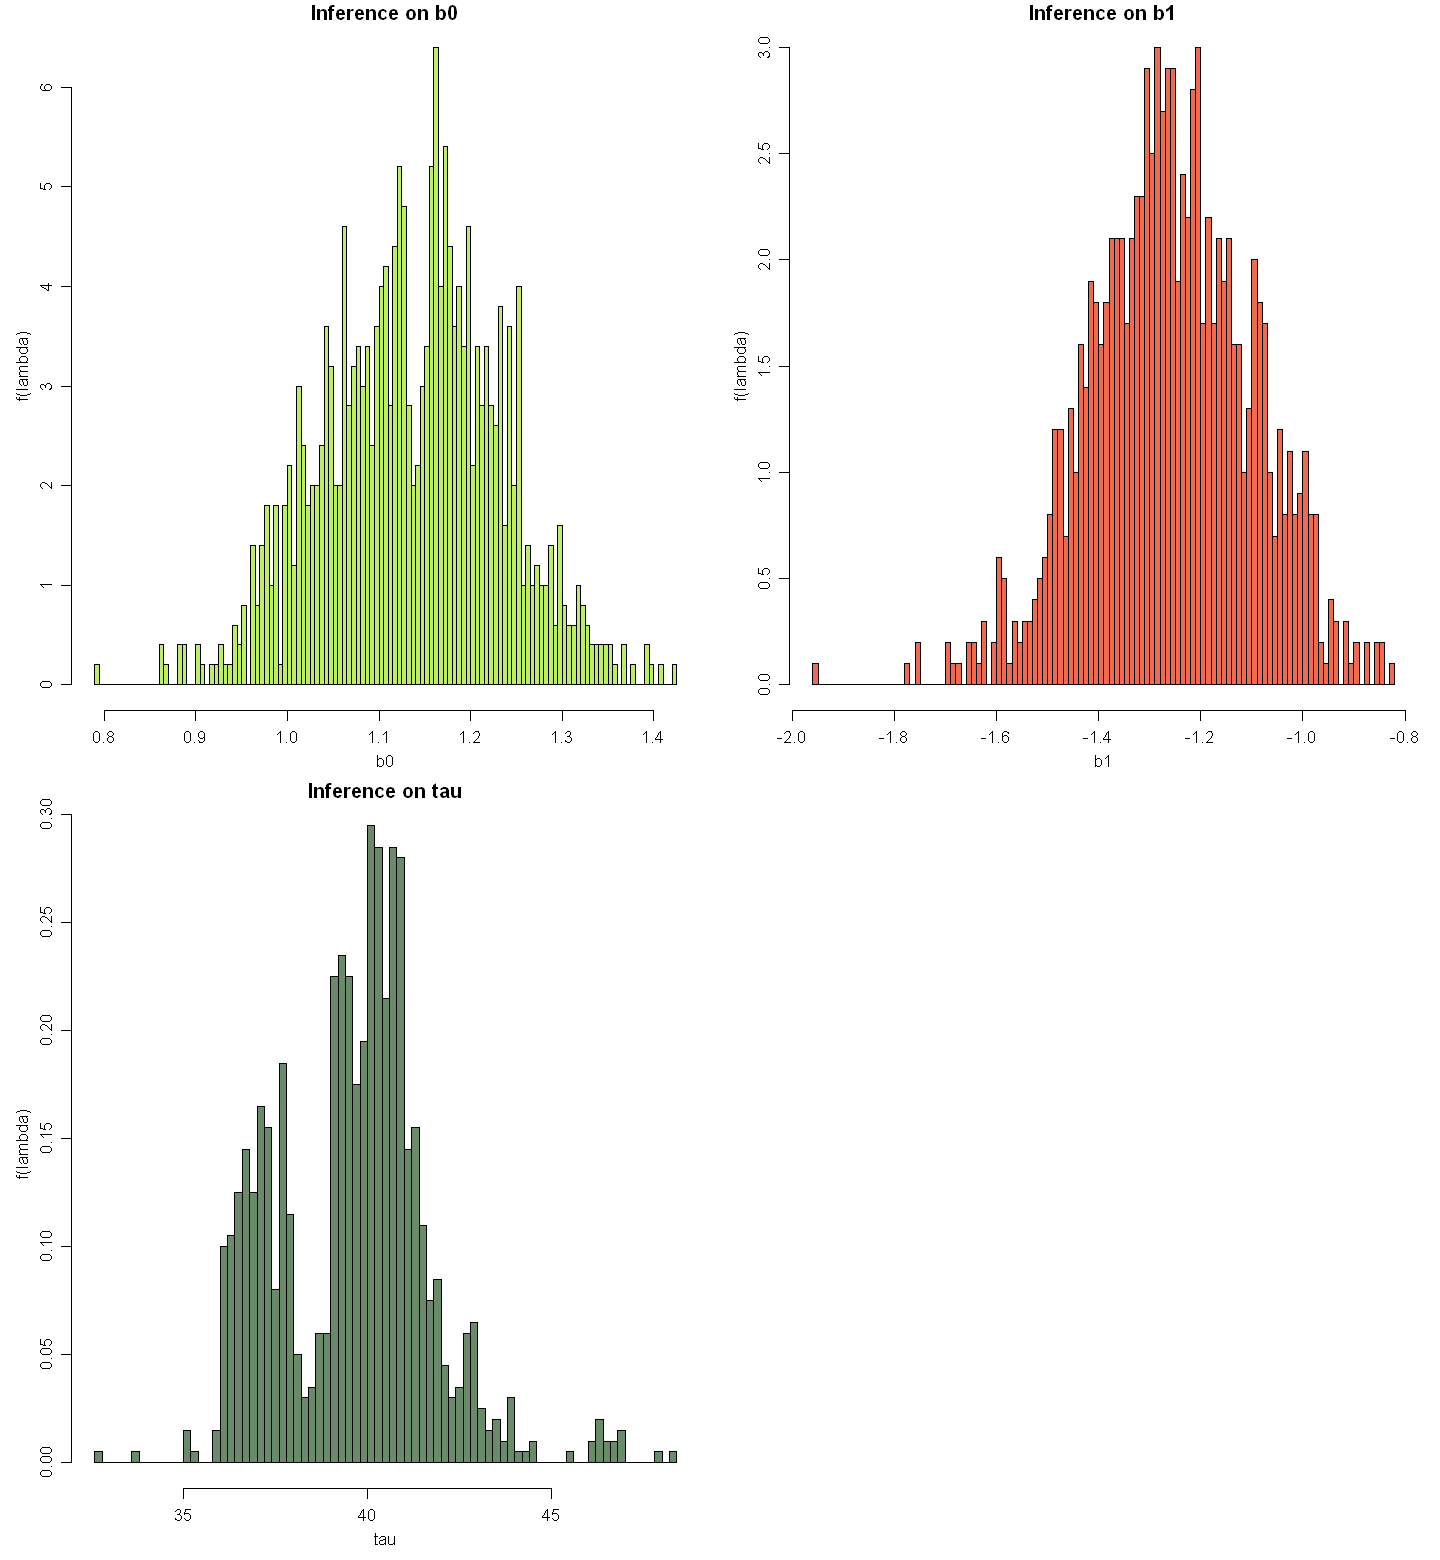

In [10]:
# Let's format our chain
chain.df <- as.data.frame( as.mcmc(chain) )
options(repr.plot.width=12, repr.plot.height=13)

prob_plot <- TRUE
if (prob_plot) {
  par(mfrow=c(2,2), mgp=c(2.0,0.8,0), mar=c(3.5,3.5,1,1), oma=0.1*c(1,1,1,1))
  hist(chain.df$b0, nc=100, prob=TRUE, col='darkolivegreen2',
      # xlim=c(35, 45),
       xlab='b0', ylab='f(lambda)', main='Inference on b0')

      hist(chain.df$b1, nc=100, prob=TRUE, col='coral2',
      # xlim=c(35, 45),
       xlab='b1', ylab='f(lambda)', main='Inference on b1')

      hist(chain.df$tau, nc=100, prob=TRUE, col='darkseagreen4',
      # xlim=c(35, 45),
       xlab='tau', ylab='f(lambda)', main='Inference on tau')

 }



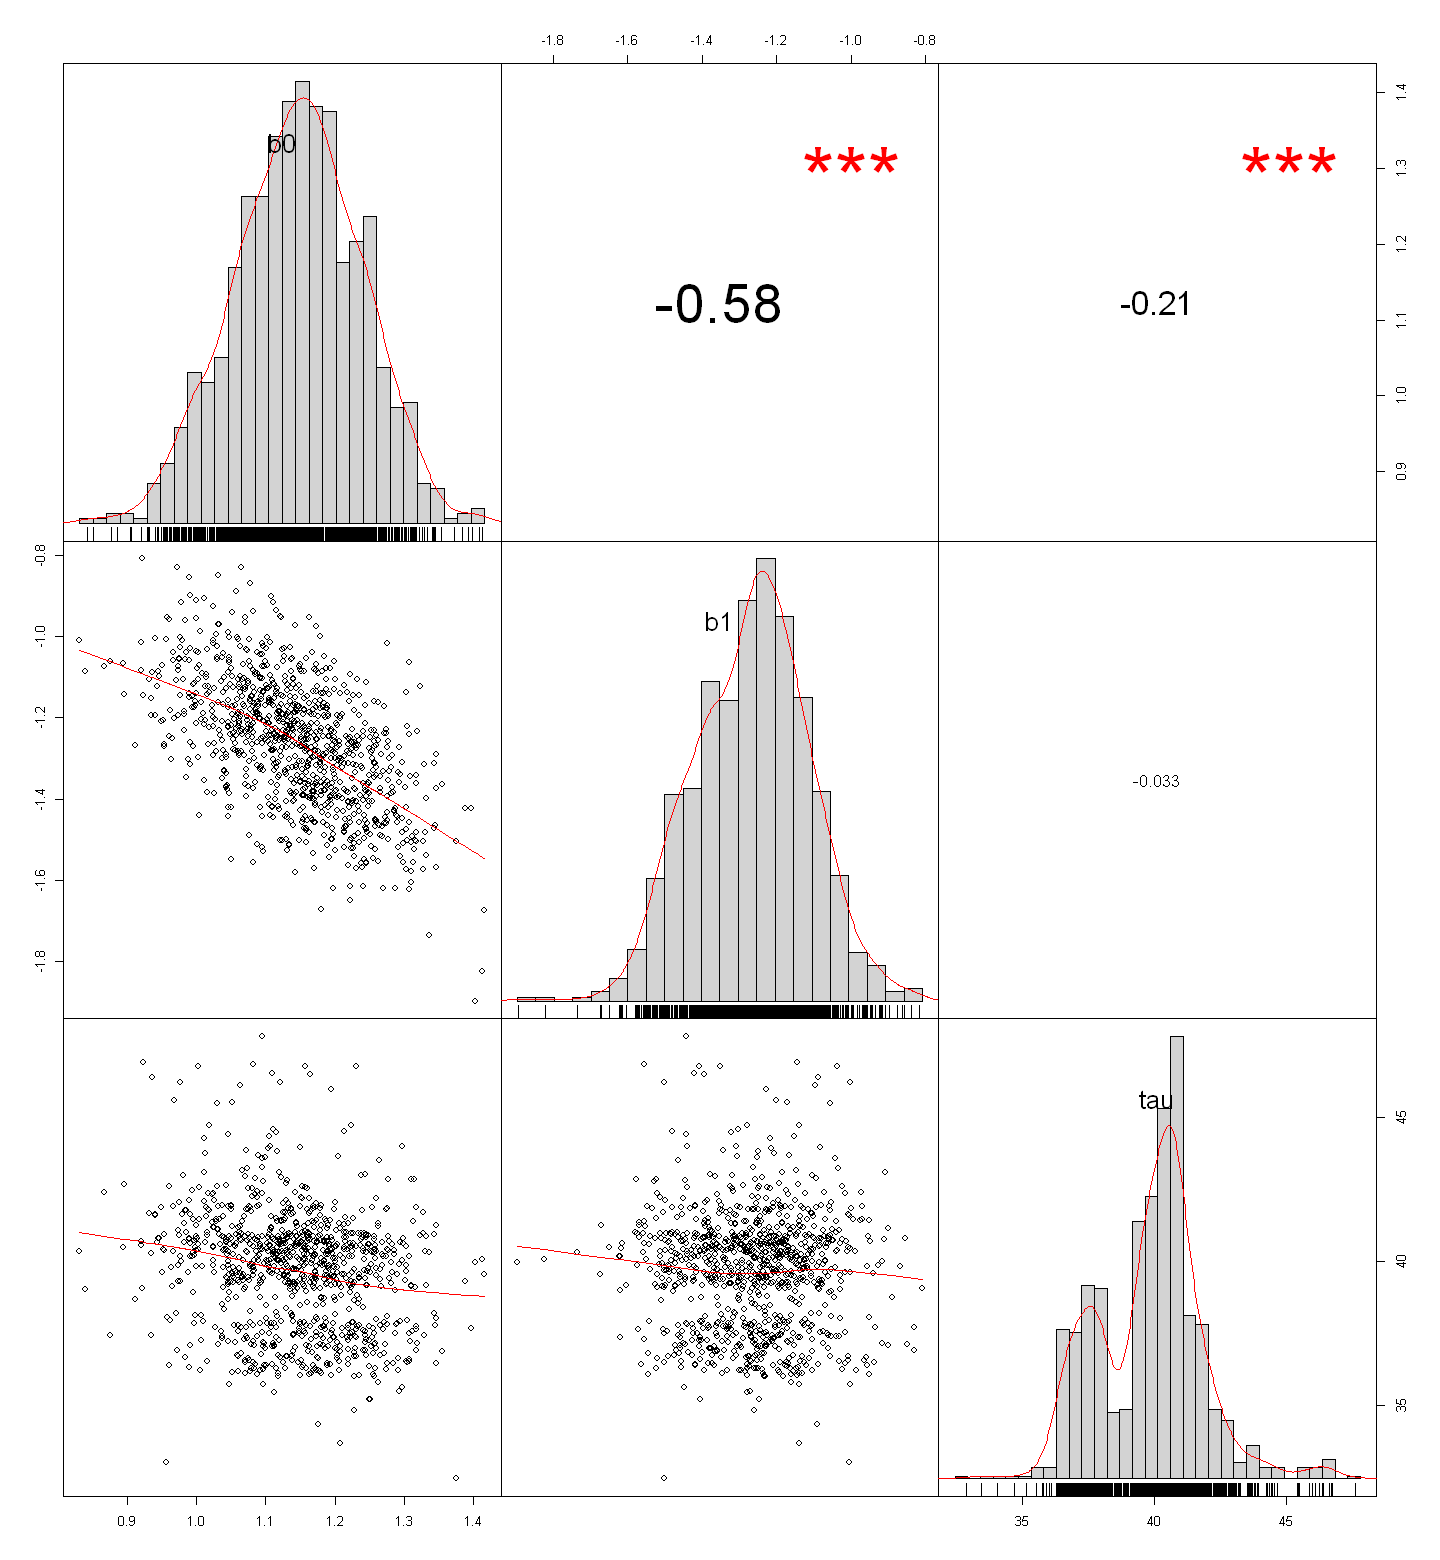

In [23]:
chart.Correlation(chain.df, histogram = T, pch= 19)

In [11]:
"or by hand"
print(cor(chain.df))

[1] "or by hand"

            b0          b1         tau
b0   1.0000000 -0.58976657 -0.27270571
b1  -0.5897666  1.00000000 -0.01830162
tau -0.2727057 -0.01830162  1.00000000


b0 and b1 are highly negatively correlated. The lowest correlation is between b1 and tau.

In [24]:
thin <- c(1, 5,  10, 15, 20, 30, 50, 100, 200, 300, 400, 500, 600, 1000, 1100, 1500, 2000)
stat.mean <- c()
b0.mean <- data.frame()
b1.mean <- data.frame()
tau.mean <- data.frame()
for (t in thin){
    update(jm, 1000)
    chain <- coda.samples(jm,  variable.names=c("b0","b1","tau"),
                      n.iter=1e5, thin = t)
    summ <- summary(chain)
    b0.mean<-rbind(b0.mean,summ$statistics[1,1:2])
    b1.mean<-rbind(b1.mean,summ$statistics[2,1:2])
    tau.mean<-rbind(tau.mean,summ$statistics[3,1:2])
}



In [25]:
colnames(b0.mean)  <- c('mean b0', 'sd b0')
colnames(b1.mean)  <- c('mean b1', 'sd b1')
colnames(tau.mean)  <- c('mean tau', 'sd tau')

df <- data.frame(b0.mean, b1.mean, tau.mean, thin)

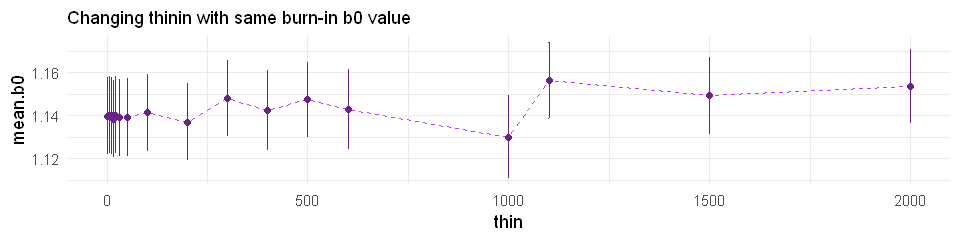

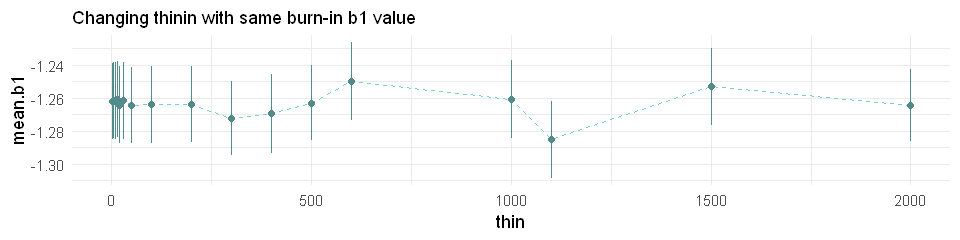

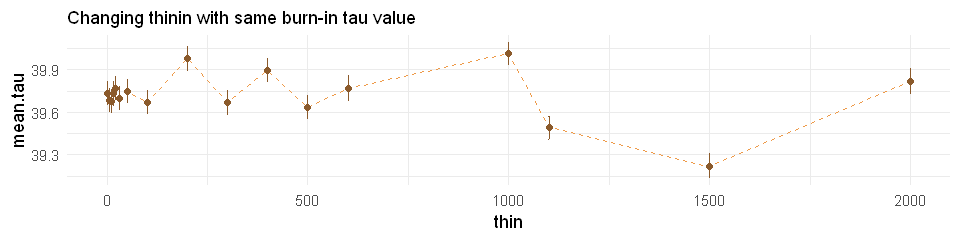

In [26]:
options(repr.plot.width=8, repr.plot.height=2)
g <- ggplot(df, aes(x= thin, y=mean.b0)) + geom_line(linetype = "dashed", col = 'darkorchid1') +geom_point(col="darkorchid4")
g <- g +  theme_minimal() +labs(subtitle = "Changing thinin with same burn-in b0 value")
g <-  g + geom_errorbar(aes(ymin=mean.b0-(sqrt(sd.b0)/length(thin)), ymax=mean.b0+(sqrt(sd.b0)/length(thin))), col = "darkorchid4", width=.2, position=position_dodge(0.05))
g

g <- ggplot(df, aes(x= thin, y=mean.b1)) + geom_line(linetype = "dashed", col = 'darkslategray3') +geom_point(col="darkslategray4")
g <- g +  theme_minimal() +labs(subtitle = "Changing thinin with same burn-in b1 value")
g <-  g + geom_errorbar(aes(ymin=mean.b1-(sqrt(sd.b1)/length(thin)), ymax=mean.b1+(sqrt(sd.b1)/length(thin))), col = "darkslategray4", width=.2, position=position_dodge(0.05))
g

g <- ggplot(df, aes(x= thin, y=mean.tau)) + geom_line(linetype = "dashed", col = 'tan2') +geom_point(col="tan4")
g <- g +  theme_minimal() +labs(subtitle = "Changing thinin with same burn-in tau value")
g <-  g + geom_errorbar(aes(ymin=mean.tau-(sqrt(sd.tau)/length(thin)), ymax=mean.tau+(sqrt(sd.tau)/length(thin))), col = "tan4", width=.2, position=position_dodge(0.05))
g

In [27]:
#burnin with constant thinning
burn <- c(1, 5,  10, 15, 20, 30, 50, 100, 200, 300, 400, 500, 600, 1000, 1100, 1500, 2000, 3000)
stat.mean <- c()
b0.mean <- data.frame()
b1.mean <- data.frame()
tau.mean <- data.frame()
for (b in burn){
    update(jm, b)
    chain <- coda.samples(jm,  variable.names=c("b0","b1","tau"),
                      n.iter=1e5, thin = 200)
    summ <- summary(chain)
    b0.mean<-rbind(b0.mean,summ$statistics[1,1:2])
    b1.mean<-rbind(b1.mean,summ$statistics[2,1:2])
    tau.mean<-rbind(tau.mean,summ$statistics[3,1:2])
}


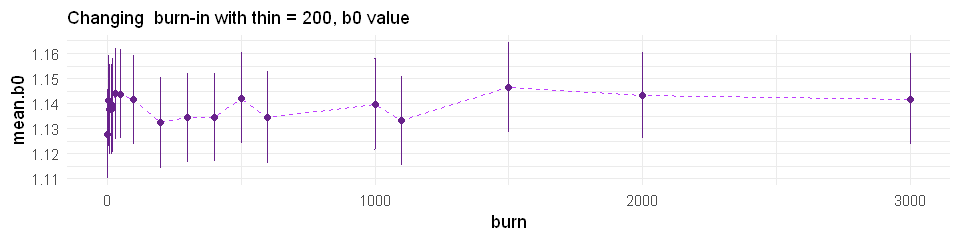

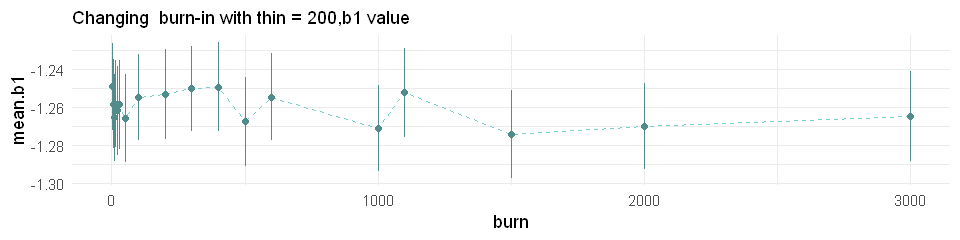

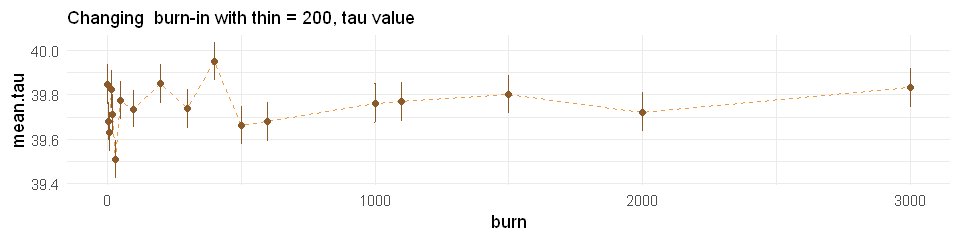

In [30]:
colnames(b0.mean)  <- c('mean b0', 'sd b0')
colnames(b1.mean)  <- c('mean b1', 'sd b1')
colnames(tau.mean)  <- c('mean tau', 'sd tau')

df <- data.frame(b0.mean, b1.mean, tau.mean, burn)

options(repr.plot.width=8, repr.plot.height=2)
g <- ggplot(df, aes(x= burn, y=mean.b0)) + geom_line(linetype = "dashed", col = 'darkorchid1') +geom_point(col="darkorchid4")
g <- g +  theme_minimal() +labs(subtitle = "Changing  burn-in with thin = 200, b0 value")
g <-  g + geom_errorbar(aes(ymin=mean.b0-(sqrt(sd.b0)/length(thin)), ymax=mean.b0+(sqrt(sd.b0)/length(thin))), col = "darkorchid4", width=.2, position=position_dodge(0.05))
g

g <- ggplot(df, aes(x= burn, y=mean.b1)) + geom_line(linetype = "dashed", col = 'darkslategray3') +geom_point(col="darkslategray4")
g <- g +  theme_minimal() +labs(subtitle = "Changing  burn-in with thin = 200,b1 value")
g <-  g + geom_errorbar(aes(ymin=mean.b1-(sqrt(sd.b1)/length(thin)), ymax=mean.b1+(sqrt(sd.b1)/length(thin))), col = "darkslategray4", width=.2, position=position_dodge(0.05))
g

g <- ggplot(df, aes(x= burn, y=mean.tau)) + geom_line(linetype = "dashed", col = 'tan2') +geom_point(col="tan4")
g <- g +  theme_minimal() +labs(subtitle = "Changing  burn-in with thin = 200, tau value")
g <-  g + geom_errorbar(aes(ymin=mean.tau-(sqrt(sd.tau)/length(thin)), ymax=mean.tau+(sqrt(sd.tau)/length(thin))), col = "tan4", width=.2, position=position_dodge(0.05))
g

Lets see what's going on with the autoccorelation

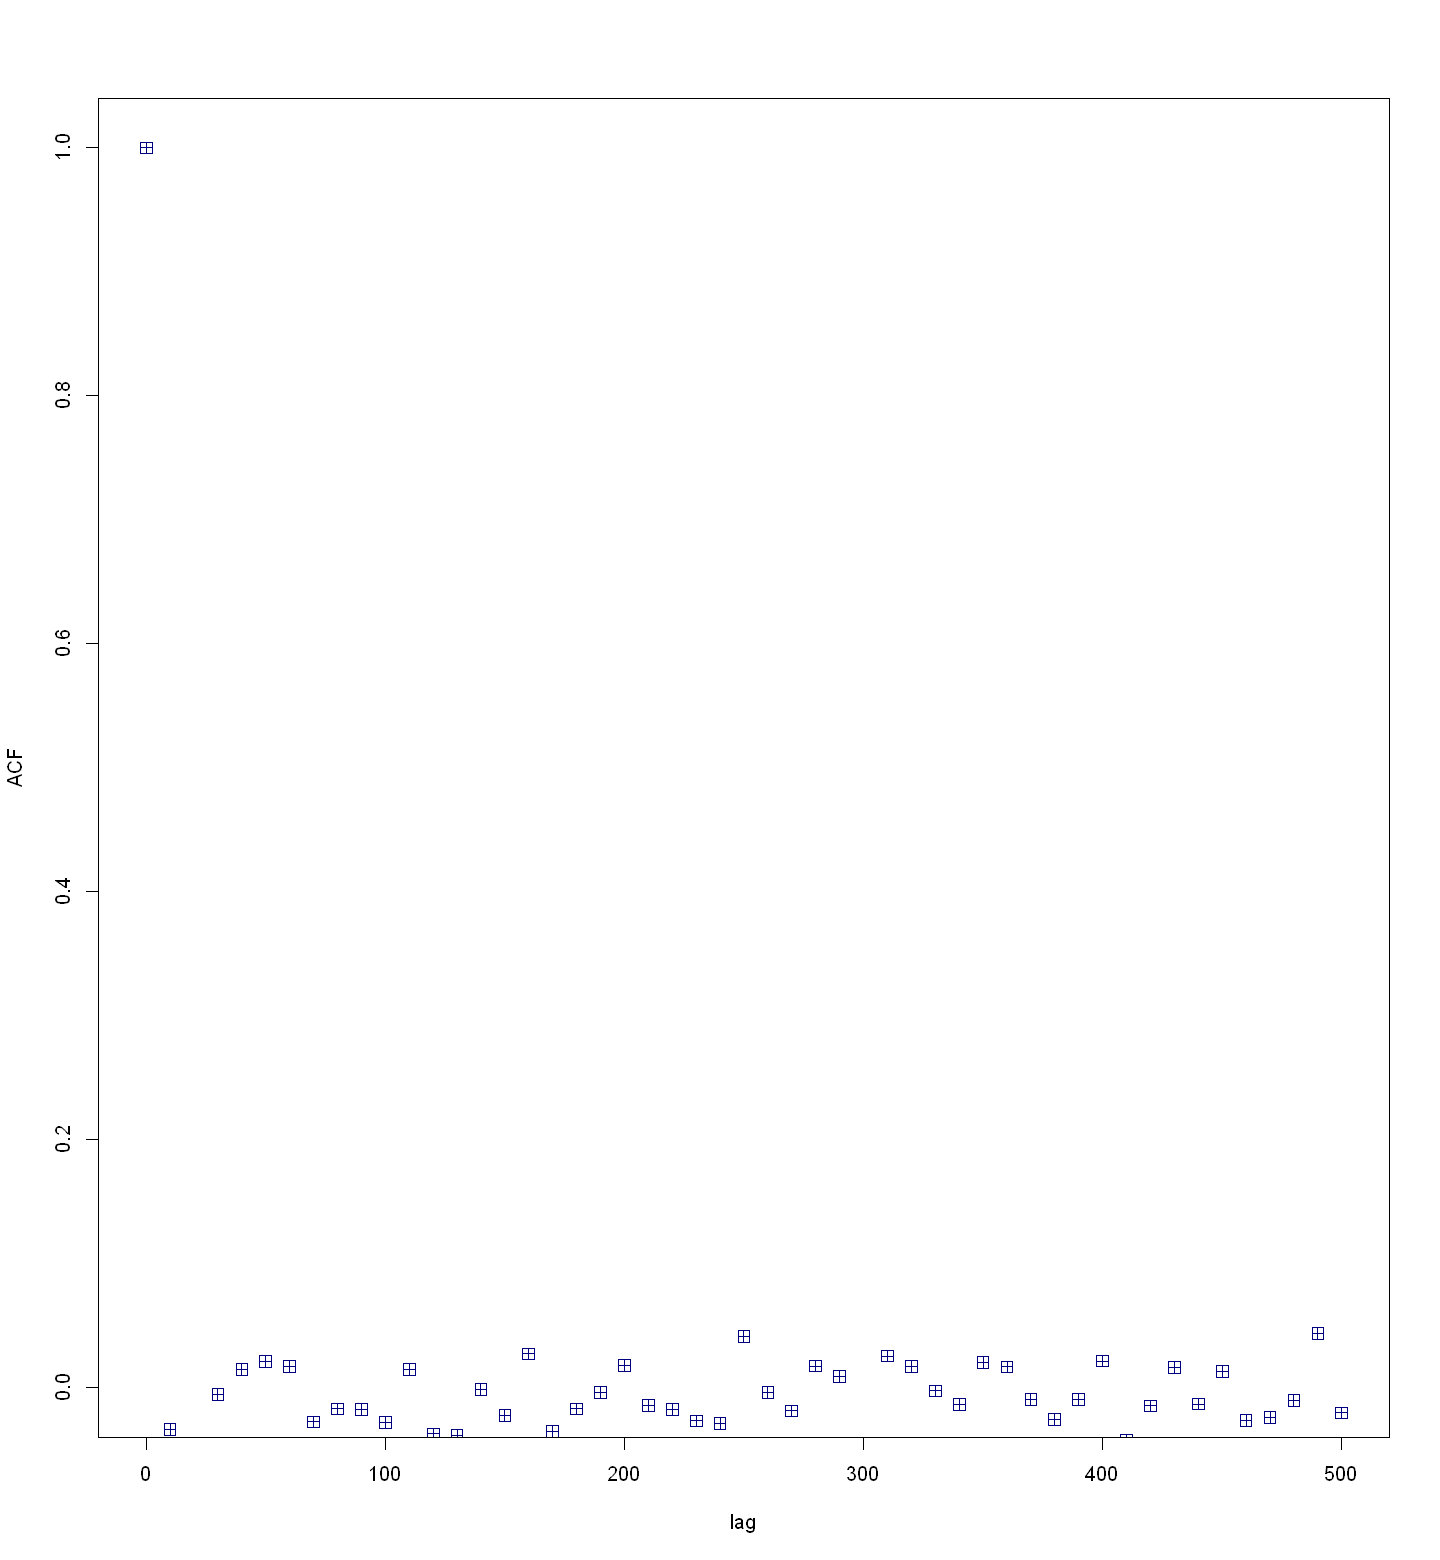

In [12]:
chain.df <- as.data.frame(as.mcmc(chain))
sec <- seq(0,500,10)
y1 <- autocorr(as.mcmc(chain.df$b0), lags = sec)
plot(sec, y1, ylim = c(0,1), pch = 12, col = "navy", xlab = "lag", ylab = 'ACF', cex=1.3)

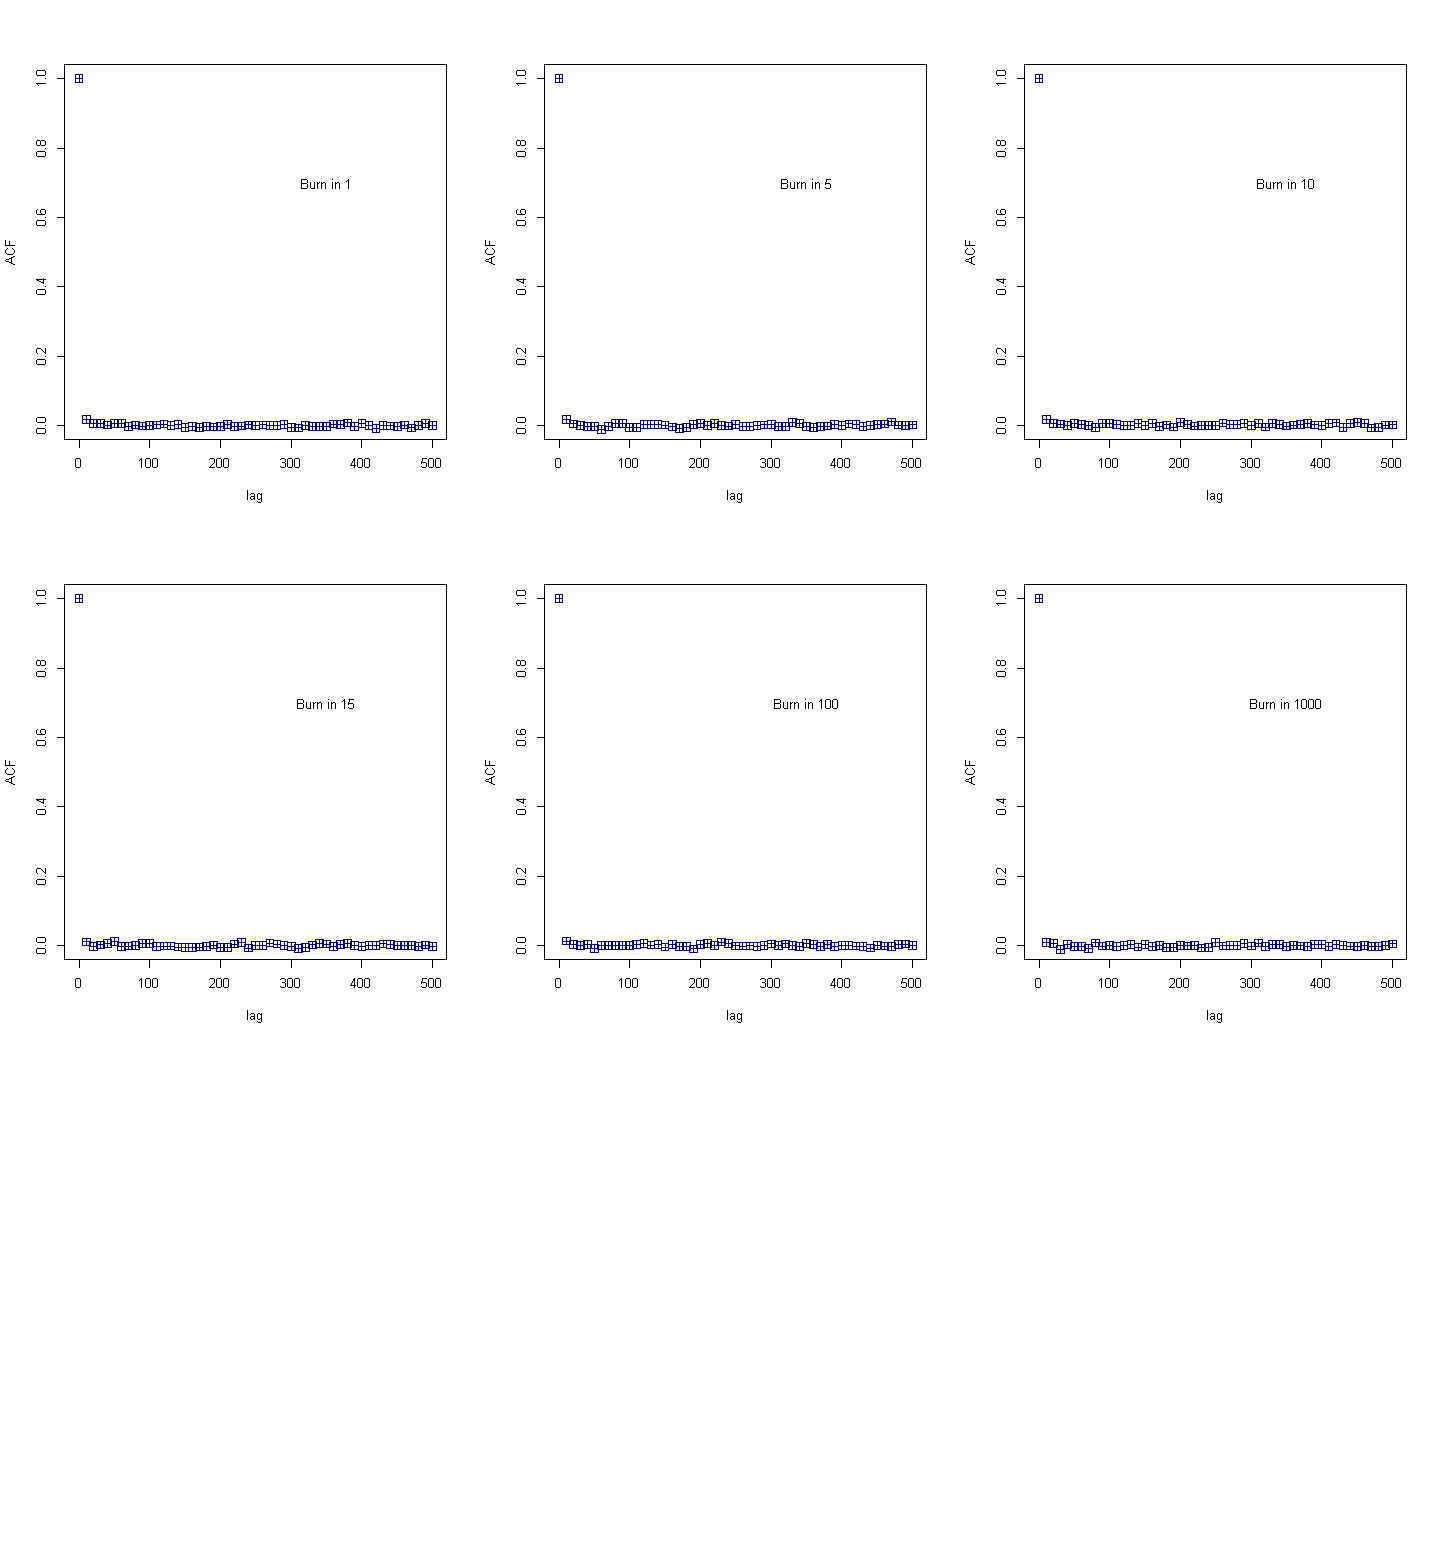

In [13]:
#Let's plot it for many values
par(mfrow = c(3, 3))

burn <- c(1, 5,  10, 15, 100, 1000)
for (b in burn){
    update(jm, b)
    chain <- coda.samples(jm,  variable.names=c("b0","b1","tau"),
                      n.iter=1e5, thin = 1)
    chain.df <- as.data.frame(as.mcmc(chain))
    sec <- seq(0,500,10)
    y1 <- autocorr(as.mcmc(chain.df$b0), lags = sec)
    plot(sec, y1, ylim = c(0,1), pch = 12, col = "navy", xlab = "lag", ylab = 'ACF', cex=1.3)
    text(350, 0.7, sprintf("Burn in %d", b))
}

The values does not change h both for burn, the only meaninful value is when thin = 1.